In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import silhouette_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist, pdist

%matplotlib inline

In [2]:
forest = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv")
forest.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
forest.shape

(517, 13)

In [4]:
forest.corr()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366


In [5]:
 # Winter = 1, Spring = 2, Summer = 3, Fall = 4
 # PERIODS
 
 month_int_season = {
    'jan' : [1, "0"],
    'feb' : [2, "0"],
    'mar' : [3, "0"],
    'apr' : [4, "0"],
    'may' : [5, "1"],
    'jun' : [6, "1"],
    'jul' : [7, "1"],
    'aug' : [8, "1"],
    'sep' : [9, "2"],
    'oct' : [10, "2"],
    'nov' : [11, "2"],
    'dec' : [12, "2"]
}

forest["month_int_season"] = forest['month'].map(month_int_season) 
forest[['month_int','season']] = pd.DataFrame(forest.month_int_season.to_list())

forest = forest.sort_values(['month_int']).reset_index(drop=True)
forest = forest.drop(["month_int_season","month","day"], axis=1)

forest.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,month_int,season
0,2,4,82.1,3.7,9.3,2.9,5.3,78,3.1,0.0,0.00,1,0
1,4,5,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00,1,0
2,3,4,83.9,8.0,30.2,2.6,12.7,48,1.8,0.0,0.00,2,0
3,2,2,86.6,13.2,43.0,5.3,12.3,51,0.9,0.0,0.00,2,0
4,7,4,83.9,8.7,32.1,2.1,8.8,68,2.2,0.0,13.05,2,0


<AxesSubplot:>

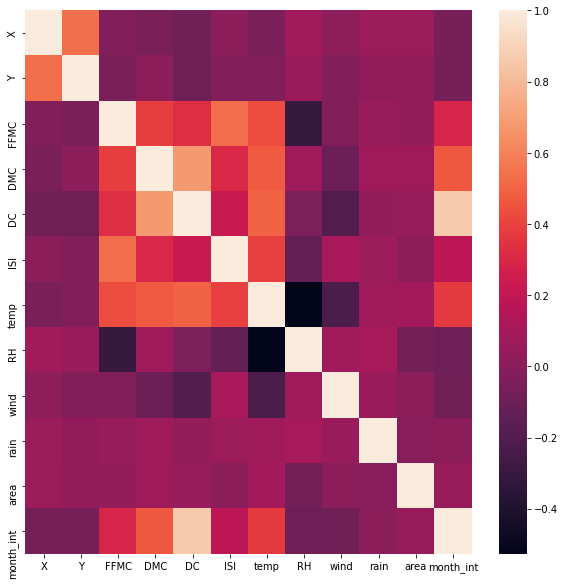

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(forest.corr())

In [7]:
# Create train and test data
x = forest.drop(['season'], axis=1)
y = forest['season']

xTrain, xTest, yTrain, yTest = train_test_split(x, y)

xTrain = pd.get_dummies(xTrain)
xTest = pd.get_dummies(xTest)

print(yTest)

203    1
477    2
434    2
350    2
265    1
      ..
86     1
244    1
412    2
401    2
53     0
Name: season, Length: 130, dtype: object


In [8]:
# Sets the seed to a number
np.random.seed(seed=1)

## How many clusters are optimal?


#### Method 1 : Change in Objective Functions (Drastic Change)

Obj. Func.: 25444952.391953997
Obj. Func.: 5568044.665901967
Obj. Func.: 3483051.347358535
Obj. Func.: 2698167.0179292886
Obj. Func.: 2149158.6198695702
Obj. Func.: 1663899.2824548683
Obj. Func.: 1368050.0582583887
Obj. Func.: 1167572.0501065617
Obj. Func.: 995437.1900898753


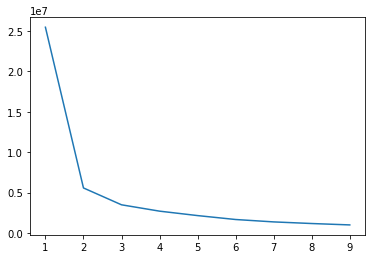

In [9]:
clusterRange = range(1,10)
objFuncs = []

for i in clusterRange:
  kmeans = KMeans(n_clusters=i).fit(xTrain)
  print("Obj. Func.:", kmeans.inertia_)
  objFuncs.append(kmeans.inertia_)

plt.plot(clusterRange, objFuncs)

#### Method 2: Variance Explained vs. # of clusters

Text(0.5, 1.0, 'Variance vs Number of Clusters')

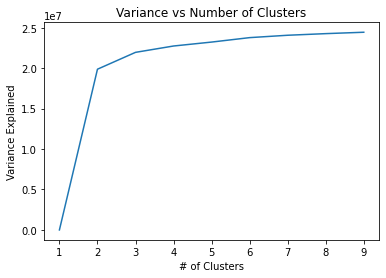

In [10]:
# Pick the one where the variance stops changing abruptly

clusterRange = range(1,10)

# First the model for each n_clusters
kMeansModels = [KMeans(n_clusters=k).fit(xTrain) for k in clusterRange]

centroids = [x.cluster_centers_ for x in kMeansModels]

# Calculate the distant from each point to each cluster center
euclid = [cdist(xTrain, centroid, 'euclidean') for centroid in centroids]
dist = [np.min(ke, axis=1) for ke in euclid]

# Total Within Cluster Sum of Squares
wcss = [sum(d**2) for d in dist]

# Total sum of Squares
tss = sum(pdist(xTrain)**2/xTrain.shape[0])

# Between cluster sum of squares
bss = tss - wcss

plt.plot(list(clusterRange), bss)
plt.xlabel('# of Clusters')
plt.ylabel('Variance Explained')
plt.title('Variance vs Number of Clusters')

#### Method 3: Within Cluster SSE

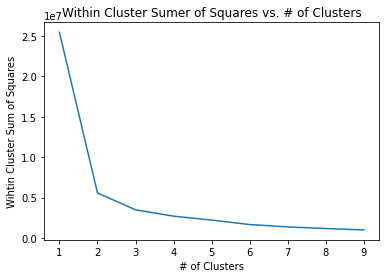

In [11]:
# Elbow plot: At what value of k, the distance between the mean of a cluster and the other data points in the cluster is at its lowest

plt.plot(list(clusterRange), wcss)
plt.xlabel('# of Clusters')
plt.ylabel("Wihtin Cluster Sum of Squares")
plt.title("Within Cluster Sumer of Squares vs. # of Clusters")

plt.show()

In [12]:
# Helper function
def pca(x, cluster):
  pca = PCA(n_components=2).fit(x)
  pcaTrans = pca.transform(x)
  pcaTransDf = pd.DataFrame(pcaTrans, columns=["pca1","pca2"])
  pca_means = pd.concat([cluster, pcaTransDf], axis=1)  
  return pca_means

def pca_plot(num, x):
  pca = PCA(n_components=num)
  princialComponents = pca.fit_transform(x)
  features = range(pca.n_components_)
  plt.bar(features, pca.explained_variance_ratio_, color='black')
  plt.xlabel('PCA features')
  plt.ylabel('variance %')
  plt.xticks(features)

def plot_normalizer_pca(pca_means, title):
  fig = sns.lmplot(x="pca1", y="pca2", data=pca_means, hue="cluster", fit_reg=False)
  plt.title(title)
  plt.show()

def kmeans(x):
  kmeans = KMeans(n_clusters=3).fit(x)
  kmeans_df = pd.DataFrame(kmeans.labels_, columns=["cluster"])
  return kmeans, kmeans_df

def agglomerative(x):
  agglomerative = AgglomerativeClustering(n_clusters=3).fit(x)
  agglomerative_df = pd.DataFrame(agglomerative.labels_, columns=["cluster"])
  return agglomerative, agglomerative_df

def spectral(x):
  spectral = SpectralClustering(n_clusters=3).fit(x)
  spectral_df = pd.DataFrame(spectral.labels_, columns=["cluster"])
  return spectral, spectral_df

In [13]:
print(yTest.unique())

['1' '2' '0']


## KMeans Clustering

StdScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.60      0.42      0.49       180
           2       0.13      0.07      0.09       147

    accuracy                           0.22       387
   macro avg       0.24      0.16      0.19       387
weighted avg       0.33      0.22      0.26       387



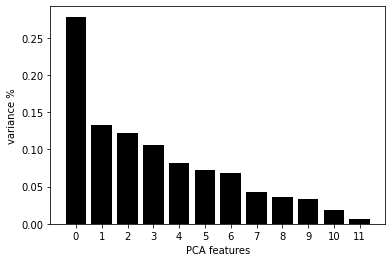

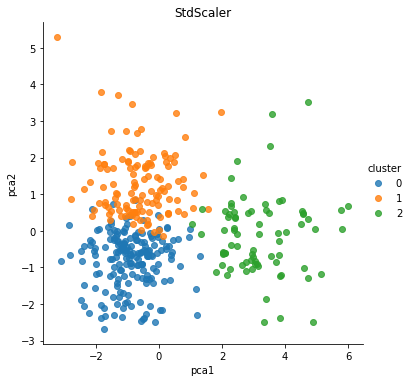



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.56      0.44      0.49       180
           2       0.11      0.05      0.07       147

    accuracy                           0.22       387
   macro avg       0.22      0.16      0.19       387
weighted avg       0.30      0.22      0.26       387



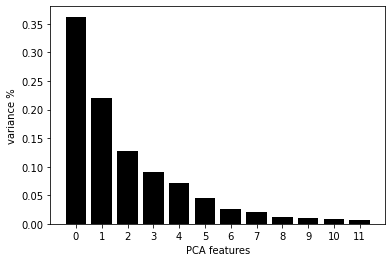

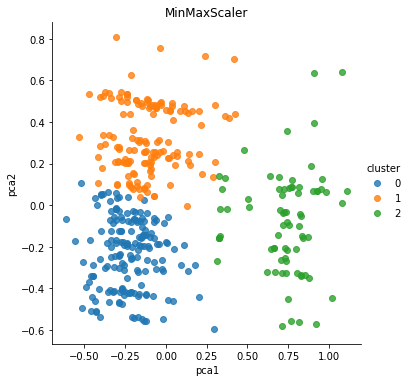



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.05      0.02      0.02       180
           2       0.79      0.88      0.83       147

    accuracy                           0.34       387
   macro avg       0.28      0.30      0.29       387
weighted avg       0.32      0.34      0.33       387



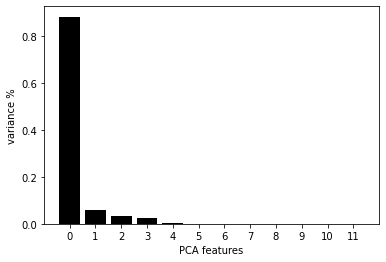

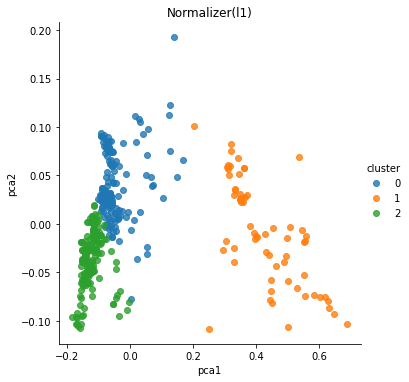



Normalizer(l2)
              precision    recall  f1-score   support

           0       0.00      0.02      0.01        60
           1       0.00      0.00      0.00       180
           2       0.03      0.01      0.01       147

    accuracy                           0.01       387
   macro avg       0.01      0.01      0.01       387
weighted avg       0.01      0.01      0.01       387



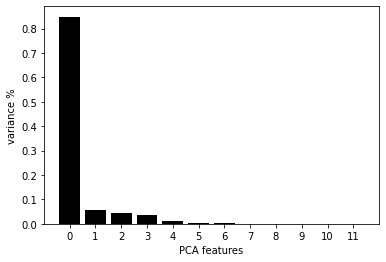

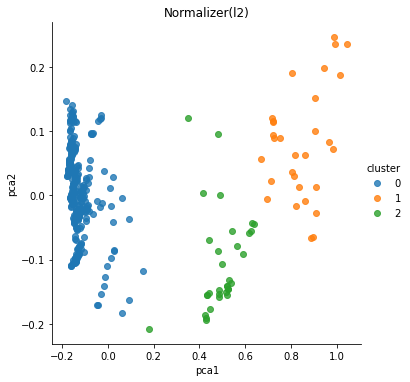



Normalizer(Max)
              precision    recall  f1-score   support

           0       0.00      0.02      0.01        60
           1       0.06      0.01      0.02       180
           2       0.00      0.00      0.00       147

    accuracy                           0.01       387
   macro avg       0.02      0.01      0.01       387
weighted avg       0.03      0.01      0.01       387



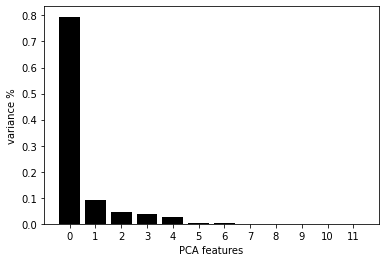

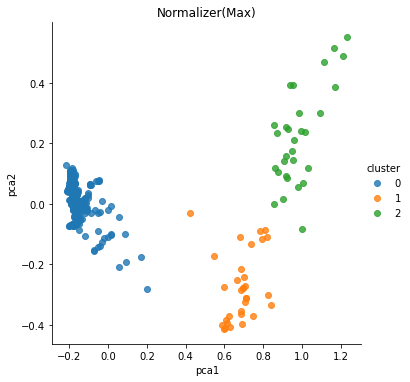

In [15]:
# KMeans with PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

# With PCA
for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,kmeans(X)[1]))

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,kmeans(X)[1]))
    
trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

pca_stdscaler = scaler_list[0]
pca_minMaxScaler = scaler_list[1]
pca_normalizer_l1 = scaler_list[2]
pca_normalizer_l2 = scaler_list[3]
pca_normalizer_max = scaler_list[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]
pca_list = [pca_stdscaler, pca_minMaxScaler, pca_normalizer_l1, pca_normalizer_l2, pca_normalizer_max]

for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  pca_plot(12, pca_list[index])
  print(classification_report(y_train, y_pred))
  plot_normalizer_pca(transform[index], title=title[index])
  print("\n")

In [16]:
# KMeans with NO PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

# With NO PCA
for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(kmeans(X)[1])

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(kmeans(X)[1])

trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]

for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  print(classification_report(y_train, y_pred))
  print("\n")

StdScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       1.00      0.02      0.03       180
           2       0.12      0.07      0.09       147

    accuracy                           0.03       387
   macro avg       0.37      0.03      0.04       387
weighted avg       0.51      0.03      0.05       387



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.55      0.52      0.54       180
           2       0.11      0.05      0.07       147

    accuracy                           0.26       387
   macro avg       0.22      0.19      0.20       387
weighted avg       0.30      0.26      0.28       387



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.05      0.02      0.02       180
           2       0.78      0.88

## Agglomerative Clustering

StdScaler
              precision    recall  f1-score   support

           0       0.01      0.05      0.02        60
           1       0.03      0.01      0.02       180
           2       0.00      0.00      0.00       147

    accuracy                           0.01       387
   macro avg       0.01      0.02      0.01       387
weighted avg       0.01      0.01      0.01       387



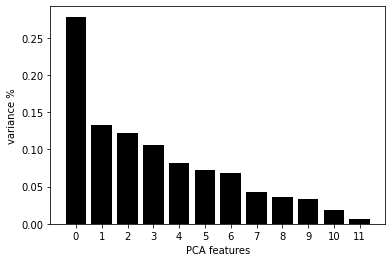

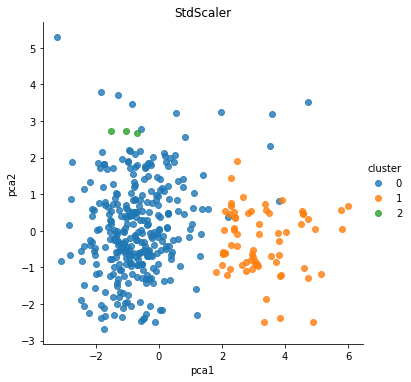



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.06      0.02      0.03       180
           2       0.42      0.34      0.37       147

    accuracy                           0.14       387
   macro avg       0.16      0.12      0.14       387
weighted avg       0.19      0.14      0.16       387



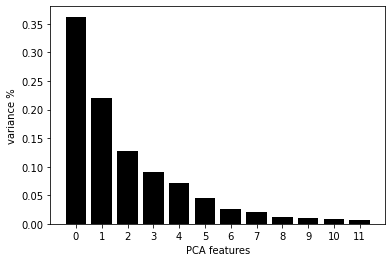

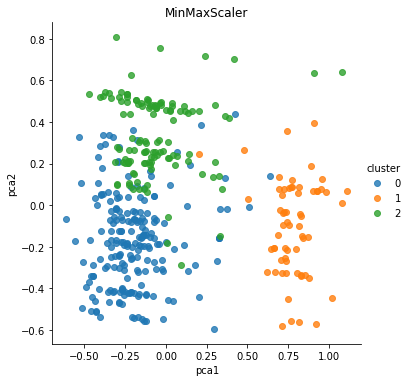



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.74      0.96      0.84       180
           2       0.95      0.59      0.72       147

    accuracy                           0.82       387
   macro avg       0.88      0.84      0.84       387
weighted avg       0.85      0.82      0.81       387



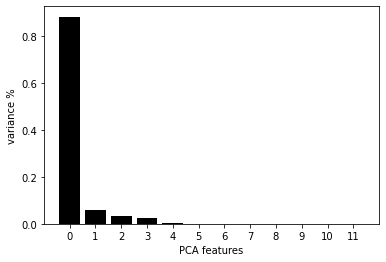

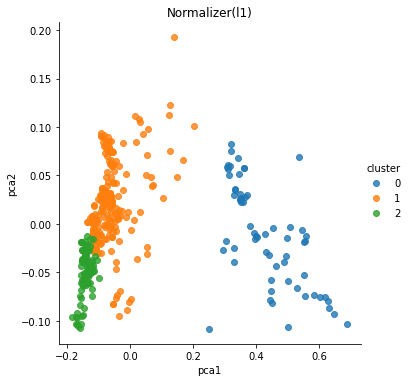



Normalizer(l2)
              precision    recall  f1-score   support

           0       0.00      0.02      0.01        60
           1       0.00      0.00      0.00       180
           2       0.03      0.01      0.01       147

    accuracy                           0.01       387
   macro avg       0.01      0.01      0.01       387
weighted avg       0.01      0.01      0.01       387



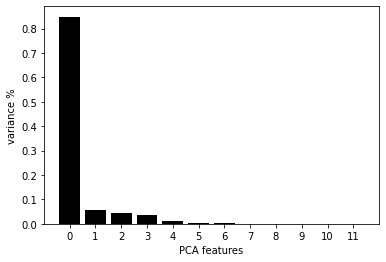

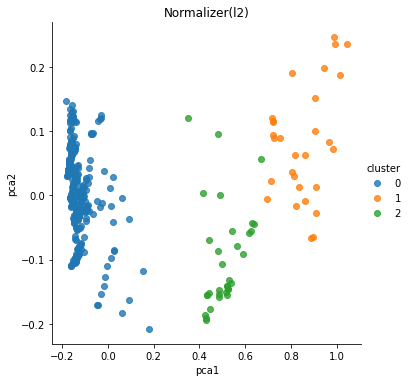



Normalizer(Max)
              precision    recall  f1-score   support

           0       0.00      0.02      0.01        60
           1       0.00      0.00      0.00       180
           2       0.03      0.01      0.01       147

    accuracy                           0.01       387
   macro avg       0.01      0.01      0.01       387
weighted avg       0.01      0.01      0.01       387



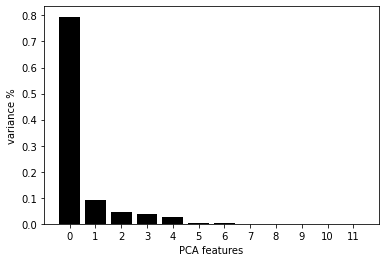

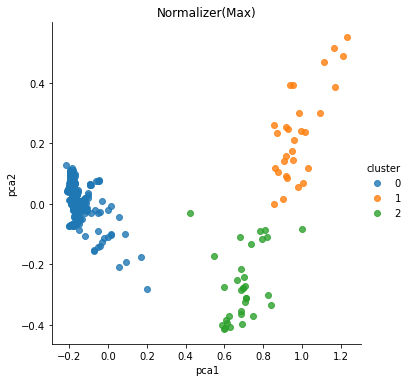

In [18]:
# Agglomerative with PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,agglomerative(X)[1]))
      
      # yPred = kmeans(X)[0].predict(xTest)
      # error.append(f1_score(yTest.astype(int), yPred, average="micro"))
      # predict.append(yPred)

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,agglomerative(X)[1]))

trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

pca_stdscaler = scaler_list[0]
pca_minMaxScaler = scaler_list[1]
pca_normalizer_l1 = scaler_list[2]
pca_normalizer_l2 = scaler_list[3]
pca_normalizer_max = scaler_list[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]
pca_list = [pca_stdscaler, pca_minMaxScaler, pca_normalizer_l1, pca_normalizer_l2, pca_normalizer_max]

for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  pca_plot(12, pca_list[index])
  print(classification_report(y_train, y_pred))
  plot_normalizer_pca(transform[index], title=title[index])
  print("\n")




In [19]:
# Agglomerative WITHOUT PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(agglomerative(X)[1])

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(agglomerative(X)[1])

trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]

for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  print(classification_report(y_train, y_pred))
  print("\n")

StdScaler
              precision    recall  f1-score   support

           0       0.01      0.05      0.02        60
           1       0.03      0.01      0.02       180
           2       0.00      0.00      0.00       147

    accuracy                           0.01       387
   macro avg       0.01      0.02      0.01       387
weighted avg       0.01      0.01      0.01       387



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.06      0.02      0.03       180
           2       0.42      0.34      0.37       147

    accuracy                           0.14       387
   macro avg       0.16      0.12      0.14       387
weighted avg       0.19      0.14      0.16       387



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.74      0.96      0.84       180
           2       0.95      0.59

## Spectral Clustering

StdScaler
              precision    recall  f1-score   support

           0       0.16      1.00      0.27        60
           1       1.00      0.01      0.01       180
           2       0.00      0.00      0.00       147

    accuracy                           0.16       387
   macro avg       0.39      0.34      0.09       387
weighted avg       0.49      0.16      0.05       387



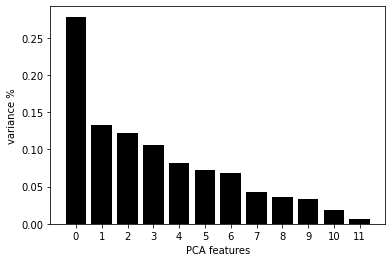

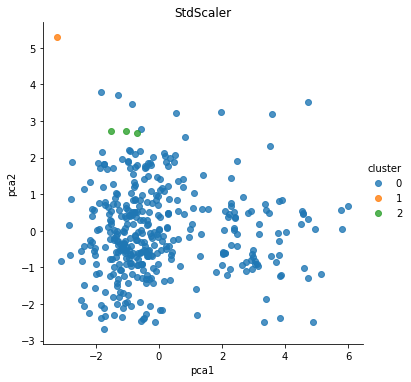



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.55      0.54      0.54       180
           2       0.02      0.01      0.01       147

    accuracy                           0.25       387
   macro avg       0.19      0.18      0.18       387
weighted avg       0.26      0.25      0.26       387



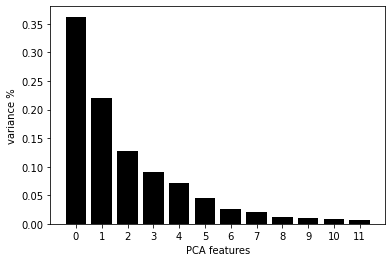

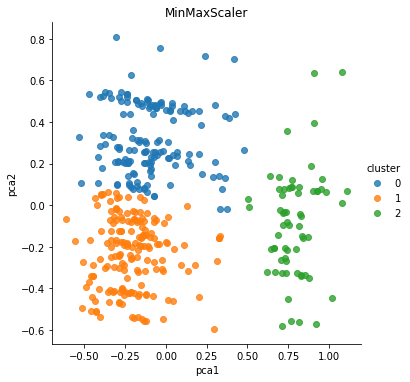



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.01      0.02      0.01        60
           1       0.04      0.01      0.02       180
           2       0.10      0.11      0.11       147

    accuracy                           0.05       387
   macro avg       0.05      0.05      0.04       387
weighted avg       0.06      0.05      0.05       387



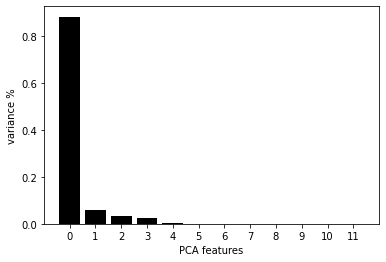

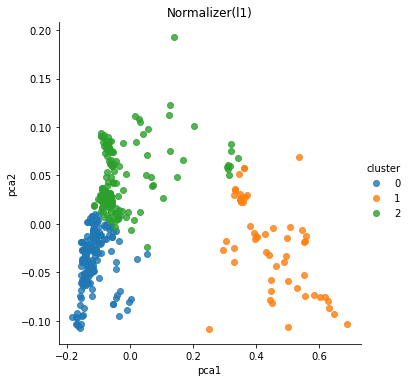



Normalizer(l2)
              precision    recall  f1-score   support

           0       0.00      0.02      0.01        60
           1       0.00      0.00      0.00       180
           2       0.03      0.01      0.01       147

    accuracy                           0.01       387
   macro avg       0.01      0.01      0.01       387
weighted avg       0.01      0.01      0.00       387



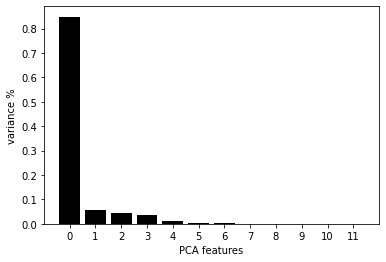

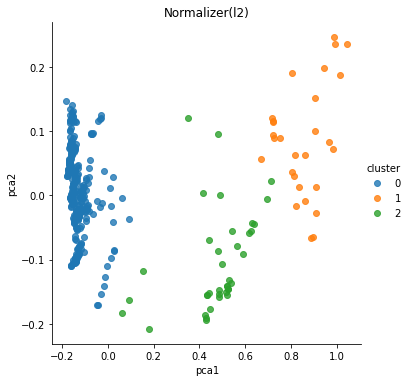



Normalizer(Max)
              precision    recall  f1-score   support

           0       0.92      0.57      0.70        60
           1       0.55      0.99      0.70       180
           2       0.00      0.00      0.00       147

    accuracy                           0.55       387
   macro avg       0.49      0.52      0.47       387
weighted avg       0.40      0.55      0.44       387



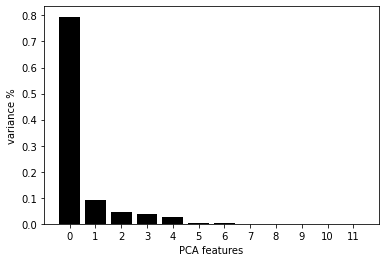

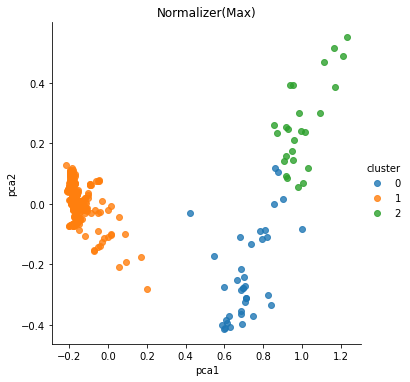

In [20]:
# Spectral with PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,spectral(X)[1]))

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(pca(X,spectral(X)[1]))

trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

pca_stdscaler = scaler_list[0]
pca_minMaxScaler = scaler_list[1]
pca_normalizer_l1 = scaler_list[2]
pca_normalizer_l2 = scaler_list[3]
pca_normalizer_max = scaler_list[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]
pca_list = [pca_stdscaler, pca_minMaxScaler, pca_normalizer_l1, pca_normalizer_l2, pca_normalizer_max]

for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  pca_plot(12, pca_list[index])
  print(classification_report(y_train, y_pred))
  plot_normalizer_pca(transform[index], title=title[index])
  print("\n")

In [21]:
# Spectral WITHOUT PCA
normalizer = [StandardScaler(), MinMaxScaler(), Normalizer()]
norm_list = ['l1','l2','max']
title = ['StdScaler','MinMaxScaler','Normalizer(l1)','Normalizer(l2)','Normalizer(Max)']
transform = []
scaler_list = []

for i in normalizer:
  if i == normalizer[-1]:
    for j in norm_list:
      scaler = Normalizer(norm=j)
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(spectral(X)[1])

  else:
      scaler = i
      X = scaler.fit_transform(xTrain)
      scaler_list.append(X)
      transform.append(spectral(X)[1])

trans_stdscaler = transform[0]
trans_minMaxScaler = transform[1]
trans_normalizer_l1 = transform[2]
trans_normalizer_l2 = transform[3]
trans_normalizer_max = transform[4]

trans_list = [trans_stdscaler, trans_minMaxScaler, trans_normalizer_l1, trans_normalizer_l2, trans_normalizer_max]


for index, i in enumerate(trans_list, start=0):
  y_pred = i['cluster']
  y_train = yTrain.astype('int')
  print(title[index])
  print(classification_report(y_train, y_pred))
  print("\n")

StdScaler
              precision    recall  f1-score   support

           0       0.16      1.00      0.27        60
           1       1.00      0.01      0.01       180
           2       0.00      0.00      0.00       147

    accuracy                           0.16       387
   macro avg       0.39      0.34      0.09       387
weighted avg       0.49      0.16      0.05       387



MinMaxScaler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.54      0.44      0.49       180
           2       0.02      0.01      0.01       147

    accuracy                           0.21       387
   macro avg       0.19      0.15      0.17       387
weighted avg       0.26      0.21      0.23       387



Normalizer(l1)
              precision    recall  f1-score   support

           0       0.01      0.02      0.01        60
           1       0.85      0.74      0.79       180
           2       0.02      0.01

END